todo: replace zero padding with sentinel

In [33]:
import pandas as pd
import torch
import pytorch_pretrained_bert
from pytorch_pretrained_bert import BertTokenizer
from torch.utils.data import DataLoader
import numpy as np
from pytorch_pretrained_bert import BertForTokenClassification
from pytorch_pretrained_bert import BertConfig


In [2]:
data = pd.read_csv('output_30.csv')
data.columns = ['sentence_id', 'word_id', 'word', 'start_time', 'end_time', 'accuracy']
data['tmp_offset'] = -1 * (data.start_time - data.start_time.shift(-1))
data['offset'] = data.apply(lambda row: row['tmp_offset'] if row['tmp_offset'] >= 0 else row['end_time'] - row['start_time'], axis=1)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
data['tokenized'] = data.word.apply(tokenizer.tokenize)
data['token_id'] = data.tokenized.apply(tokenizer.convert_tokens_to_ids)
data['sentence_length'] = data.sentence_id.map(data.groupby('sentence_id').count().token_id)
data.loc[:, 'first_token_id'] = data.token_id.map(lambda x: x[0])

data.head(40)

,sentence_id,word_id,word,start_time,end_time,accuracy,tmp_offset,offset,tokenized,token_id,sentence_length,first_token_id
0,1,1,Mr,0.50,0.78,0.87,0.28,0.28,[mr],[2720],16,2720
1,1,2,quilter,0.78,1.20,0.87,0.42,0.42,"[quilt, ##er]","[27565, 2121]",16,27565
2,1,3,is,1.20,1.39,0.87,0.19,0.19,[is],[2003],16,2003
3,1,4,the,1.39,1.51,0.87,0.12,0.12,[the],[1996],16,1996
4,1,5,apostle,1.51,2.08,0.87,0.57,0.57,[apostle],[20121],16,20121
5,1,6,of,2.08,2.24,0.87,0.16,0.16,[of],[1997],16,1997
6,1,7,the,2.24,2.34,0.87,0.10,0.10,[the],[1996],16,1996
7,1,8,middle,2.34,2.58,0.87,0.24,0.24,[middle],[2690],16,2690
8,1,9,classes,2.58,3.26,0.87,0.71,0.71,[classes],[4280],16,4280
9,1,10,and,3.29,3.44,0.87,0.15,0.15,[and],[1998],16,1998


In [4]:
class WordsDataset:
    def __init__(self, dataframe):
        self.data = dataframe
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, item):
        return (np.expand_dims(self.data.iloc[item].token_id[0], axis=1), 
                np.expand_dims(self.data.iloc[item].offset,      axis=1))
    
class SentencesDataset:
    def __init__(self, dataframe, maximum_sentence_length=None):
        self.data = dataframe
        if maximum_sentence_length:
            self.maximum_sentence_length = maximum_sentence_length
        else:
            self.maximum_sentence_length = self.data.sentence_length.max()
        print(f"max sentence length set to {self.maximum_sentence_length}.")
    
    def __len__(self):
        return self.data.sentence_id.max()
    
    def __getitem__(self, item):
        unpadded_ids =     self.data[data.sentence_id == item].first_token_id.values
        unpadded_offsets = self.data[data.sentence_id == item].offset.values
        
        if len(unpadded_ids) == self.maximum_sentence_length:
            return unpadded_ids.astype('long'), unpadded_offsets

        leftover_space = self.maximum_sentence_length - len(unpadded_ids)
        padding = np.zeros(leftover_space)

        
        padded_ids = np.concatenate([unpadded_ids, padding]).astype('long')
        padded_offsets = np.concatenate([unpadded_offsets, padding])
        
        return padded_ids, padded_offsets

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns; sns.set(rc={'figure.figsize':(11.7,8.27)})
data.sentence_length.hist(bins=40)
data.sentence_length.mean()


In [5]:
data_val = data[data.sentence_id < 270]
data_tst = data[(data.sentence_id >= 270) & (data.sentence_id < 540)]
data_trn = data[data.sentence_id >= 540]


print(len(data_val), data_val.sentence_length.mean(), data_val.sentence_id.min(), data_val.sentence_id.max())
print(len(data_tst), data_tst.sentence_length.mean(), data_tst.sentence_id.min(), data_tst.sentence_id.max())
print(len(data_trn), data_trn.sentence_length.mean(), data_trn.sentence_id.min(), data_trn.sentence_id.max())

4124 20.1188166828322 1 269
4116 21.044703595724005 270 539
46461 21.33602376186479 540 3392


In [35]:
config = BertConfig(vocab_size_or_config_json_file=32000, 
                    hidden_size=768,
                    num_hidden_layers=12, 
                    num_attention_heads=12, 
                    intermediate_size=3072,)

model = BertForTokenClassification(config, 1)
model

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1)
            )
          )
          (intermediate): BertIntermedia

In [6]:
from sklearn.model_selection import train_test_split
import datetime


full_dataset_max = data.sentence_length.max()


dataset_val = SentencesDataset(data_val, maximum_sentence_length=full_dataset_max)
dataset_trn = SentencesDataset(data_trn, maximum_sentence_length=full_dataset_max)
dataset_tst = SentencesDataset(data_tst, maximum_sentence_length=full_dataset_max)



loader_val = DataLoader(dataset_val, batch_size=32)
loader_trn = DataLoader(dataset_trn, batch_size=32)
loader_tst = DataLoader(dataset_tst, batch_size=32)



config = BertConfig(vocab_size_or_config_json_file=32000, 
                    hidden_size=768,
                    num_hidden_layers=12, 
                    num_attention_heads=12, 
                    intermediate_size=3072,)

model = BertForTokenClassification(config, 1)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.to(device)

criterion = torch.nn.SmoothL1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.0003, momentum=0.9)

# 70 / 15 / 15

epochs = 1 # recommended 3200???
#TODO: add pickling logic
for epoch in range(epochs):
    sum_loss = 0
    start_time = datetime.datetime.now()
    for batch_index, (inputs, targets) in enumerate(loader_trn):
        print(f"\r{batch_index}/105", end="")
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        logits = model(inputs).squeeze(-1)
        loss = criterion(logits, targets.float())
        sum_loss += loss
        loss.backward()
        optimizer.step()
    end_time = datetime.datetime.now()
    print(f"\repoch: {epoch} loss: {sum_loss:4f} elapsed time: {end_time - start_time}")

max sentence length set to 30.
max sentence length set to 30.
max sentence length set to 30.


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


5/105

KeyboardInterrupt: 

In [28]:
def evaluate_model_performance(model, loader, criterion):
    with torch.no_grad():
        sum_loss = 0
        for batch_index, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(device), targets.to(device)

            logits = model(inputs).squeeze(-1)
            loss = criterion(logits, targets.float())
            sum_loss += loss
    print(f"sum loss: {sum_loss}")
    print("printing distribution of predictions and labels of batch 32")
    preds = []
    for i in logits:
        for j in i:
            preds.append(j.item())
    labels = []
    for i in targets:
        for j in i:
            labels.append(j.item())
    print(preds)
    print(labels)
    return preds, labels


    
    

In [ ]:
outputs = []
for batch_index, (inputs, targets) in enumerate(loader):
    with torch.no_grad():
        inputs, targets = inputs.to(device), targets.to(device)
        outputs.append(model(inputs))

In [ ]:
with torch.no_grad():
    sum_loss = 0
    for batch_index, (inputs, targets) in enumerate(loader_val):
        inputs, targets = inputs.to(device), targets.to(device)

        logits = model(inputs).squeeze(-1)
        loss = criterion(logits, targets.float())
        sum_loss += loss


In [ ]:
torch.save(model, 'bert_model_50_epochs_lr_0.0003.pt')

In [ ]:
sum_loss

In [ ]:
loss

In [ ]:
import matplotlib.pyplot as plt


sns.distplot(preds)
plt.title('Batch 1 Predictions')

In [ ]:
sns.distplot(labels)


In [ ]:
preds = []
for i in logits:
    for j in i:
        preds.append(j.item())
labels = []
for i in targets:
    for j in i:
        labels.append(j.item())

f, axes = plt.subplots(2, 1, figsize=(20, 7), sharex=True)
ax_top = sns.distplot(labels, ax=axes[0])
ax_bot = sns.distplot(preds, ax=axes[1])
ax_top.set_title('Labels')
ax_bot.set_title('Predictions')

In [32]:
mse_30_model = torch.load('models/bert_l30_MSE.model')
mse_30_model.eval()
preds, labels = evaluate_model_performance(mse_30_model, loader_val, torch.nn.MSELoss())

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


sum loss: 0.4797042906284332
printing distribution of predictions and labels of batch 32
[0.15689770877361298, 0.15689772367477417, 0.1568976193666458, 0.15689750015735626, 0.15689793229103088, 0.15689760446548462, 0.1568976640701294, 0.15689772367477417, 0.15689782798290253, 0.15689797699451447, 0.15689754486083984, 0.15689781308174133, 0.15689796209335327, 0.1568976491689682, 0.15689747035503387, 0.15689757466316223, 0.1568974405527115, 0.1568976193666458, 0.1568978875875473, 0.15689750015735626, 0.1568976789712906, 0.1568973958492279, 0.1568978726863861, 0.1568979024887085, 0.15689781308174133, 0.15689778327941895, 0.15689784288406372, 0.15689782798290253, 0.1568978875875473, 0.15689782798290253, 0.15689735114574432, 0.15689726173877716, 0.15689706802368164, 0.15689723193645477, 0.15689754486083984, 0.15689730644226074, 0.15689711272716522, 0.15689727663993835, 0.15689747035503387, 0.15689754486083984, 0.1568974405527115, 0.15689745545387268, 0.15689754486083984, 0.15689751505851746

In [30]:
l1_30_model = torch.load('models/bert_l30_L1.model')
l1_30_model.eval()
preds, labels = evaluate_model_performance(l1_30_model, loader_val, torch.nn.L1Loss())


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


sum loss: 1.4990735054016113
printing distribution of predictions and labels of batch 32
[0.04563185200095177, 0.04563182592391968, 0.04563186317682266, 0.04563181847333908, 0.04563187435269356, 0.04563184827566147, 0.04563191533088684, 0.04563181847333908, 0.045631926506757736, 0.04563178867101669, 0.04563188925385475, 0.045631811022758484, 0.04563188552856445, 0.04563190042972565, 0.04563186317682266, 0.045631829649209976, 0.04563188552856445, 0.045631878077983856, 0.04563185200095177, 0.04563184082508087, 0.045631811022758484, 0.04563187435269356, 0.04563184082508087, 0.04563194140791893, 0.04563192278146744, 0.04563191533088684, 0.045631952583789825, 0.04563190042972565, 0.04563193768262863, 0.04563198611140251, 0.04563180357217789, 0.04563179612159729, 0.045631833374500275, 0.045631807297468185, 0.045631881803274155, 0.04563180357217789, 0.045631781220436096, 0.045631855726242065, 0.04563190042972565, 0.04563184082508087, 0.04563193395733833, 0.04563185200095177, 0.045631930232048

In [36]:
smoothl1_30_model = torch.load('models/bert_l30_SmoothL1.model')
smoothl1_30_model.eval()
preds, labels = evaluate_model_performance(smoothl1_30_model, loader_val, torch.nn.SmoothL1Loss())


RuntimeError: CUDA out of memory. Tried to allocate 2.25 MiB (GPU 0; 15.90 GiB total capacity; 3.28 GiB already allocated; 5.56 MiB free; 7.04 MiB cached)

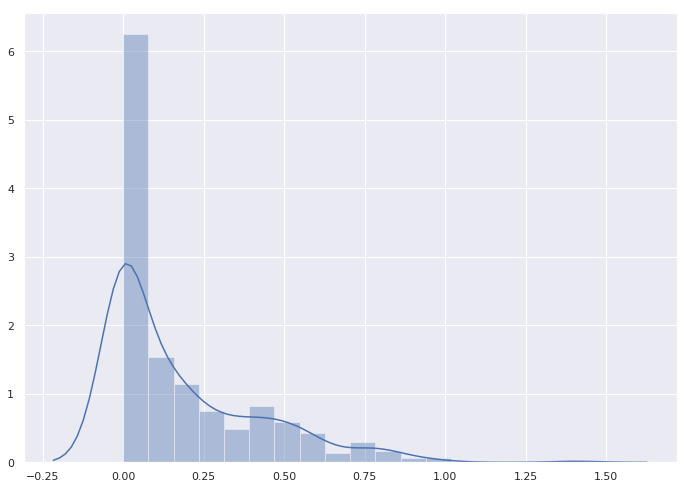

In [25]:
sns.distplot(labels)

In [37]:
a = [0.04563185200095177, 0.04563182592391968, 0.04563186317682266, 0.04563181847333908, 0.04563187435269356, 0.04563184827566147, 0.04563191533088684, 0.04563181847333908, 0.045631926506757736, 0.04563178867101669, 0.04563188925385475, 0.045631811022758484, 0.04563188552856445, 0.04563190042972565, 0.04563186317682266, 0.045631829649209976, 0.04563188552856445, 0.045631878077983856, 0.04563185200095177, 0.04563184082508087, 0.045631811022758484, 0.04563187435269356, 0.04563184082508087, 0.04563194140791893, 0.04563192278146744, 0.04563191533088684, 0.045631952583789825, 0.04563190042972565, 0.04563193768262863, 0.04563198611140251, 0.04563180357217789, 0.04563179612159729, 0.045631833374500275, 0.045631807297468185, 0.045631881803274155, 0.04563180357217789, 0.045631781220436096, 0.045631855726242065, 0.04563190042972565, 0.04563184082508087, 0.04563193395733833, 0.04563185200095177, 0.045631930232048035, 0.045631907880306244, 0.045631907880306244, 0.04563189297914505, 0.04563192278146744, 0.04563190042972565, 0.04563190042972565, 0.04563189297914505, 0.04563186317682266, 0.045631907880306244, 0.04563184827566147, 0.045631907880306244, 0.04563188552856445, 0.04563187062740326, 0.04563191905617714, 0.04563186317682266, 0.04563190042972565, 0.04563194513320923, 0.04563181847333908, 0.04563187062740326, 0.04563184827566147, 0.04563180357217789, 0.045631833374500275, 0.04563184082508087, 0.04563184827566147, 0.045631829649209976, 0.04563183709979057, 0.045631811022758484, 0.04563194885849953, 0.04563187062740326, 0.04563194513320923, 0.045631926506757736, 0.045631930232048035, 0.045631907880306244, 0.04563193768262863, 0.04563191533088684, 0.04563192278146744, 0.04563191533088684, 0.04563188552856445, 0.045631926506757736, 0.04563186317682266, 0.04563192278146744, 0.045631904155015945, 0.04563189297914505, 0.04563193395733833, 0.04563188552856445, 0.04563191905617714, 0.04563196748495102, 0.04563180357217789, 0.04563180357217789, 0.045631833374500275, 0.045631781220436096, 0.04563187062740326, 0.045631833374500275, 0.04563192278146744, 0.04563185200095177, 0.04563188552856445, 0.04563186690211296, 0.04563189297914505, 0.045631833374500275, 0.04563189297914505, 0.04563189297914505, 0.04563187435269356, 0.04563189670443535, 0.04563188552856445, 0.04563184827566147, 0.04563190042972565, 0.045631855726242065, 0.04563186317682266, 0.04563193768262863, 0.045631878077983856, 0.04563193395733833, 0.04563191533088684, 0.045631904155015945, 0.04563194140791893, 0.04563188552856445, 0.045631930232048035, 0.045631974935531616, 0.04563180357217789, 0.04563180357217789, 0.045631833374500275, 0.045631781220436096, 0.04563187062740326, 0.045631833374500275, 0.04563192278146744, 0.04563185200095177, 0.04563188552856445, 0.04563186690211296, 0.04563189297914505, 0.045631833374500275, 0.04563189297914505, 0.04563189297914505, 0.04563187435269356, 0.04563189670443535, 0.04563188552856445, 0.04563184827566147, 0.04563190042972565, 0.045631855726242065, 0.04563186317682266, 0.04563193768262863, 0.045631878077983856, 0.04563193395733833, 0.04563191533088684, 0.045631904155015945, 0.04563194140791893, 0.04563188552856445, 0.045631930232048035, 0.045631974935531616, 0.04563182592391968, 0.04563186317682266, 0.04563188552856445, 0.04563179612159729, 0.045631952583789825, 0.045631833374500275, 0.04563186317682266, 0.04563185200095177, 0.04563182592391968, 0.04563179612159729, 0.04563194140791893, 0.04563182219862938, 0.04563188925385475, 0.045631833374500275, 0.045631881803274155, 0.04563191533088684, 0.04563194885849953, 0.04563192278146744, 0.045631930232048035, 0.04563191533088684, 0.04563188552856445, 0.045631930232048035, 0.04563187062740326, 0.045631930232048035, 0.04563191160559654, 0.04563189297914505, 0.04563193768262863, 0.04563188552856445, 0.04563192278146744, 0.045631974935531616, 0.04563182592391968, 0.04563186317682266, 0.04563188552856445, 0.04563179612159729, 0.045631952583789825, 0.045631833374500275, 0.04563186317682266, 0.04563185200095177, 0.04563182592391968, 0.04563179612159729, 0.04563194140791893, 0.04563182219862938, 0.04563188925385475, 0.045631833374500275, 0.045631881803274155, 0.04563191533088684, 0.04563194885849953, 0.04563192278146744, 0.045631930232048035, 0.04563191533088684, 0.04563188552856445, 0.045631930232048035, 0.04563187062740326, 0.045631930232048035, 0.04563191160559654, 0.04563189297914505, 0.04563193768262863, 0.04563188552856445, 0.04563192278146744, 0.045631974935531616, 0.04563192278146744, 0.045631878077983856, 0.04563188552856445, 0.045631833374500275, 0.04563188925385475, 0.04563184827566147, 0.045631974935531616, 0.045631855726242065, 0.04563188925385475, 0.04563184827566147, 0.045631956309080124, 0.045631833374500275, 0.04563192278146744, 0.04563192278146744, 0.04563193768262863, 0.04563188552856445, 0.045631930232048035, 0.04563194885849953, 0.04563192278146744, 0.04563189297914505, 0.04563186690211296, 0.04563189297914505, 0.04563184827566147, 0.04563188925385475, 0.04563187062740326, 0.04563184082508087, 0.04563191533088684, 0.04563191160559654, 0.04563190042972565, 0.04563196748495102, 0.04563179984688759, 0.04563181474804878, 0.04563182219862938, 0.045631781220436096, 0.04563186690211296, 0.04563187062740326, 0.04563191160559654, 0.04563188552856445, 0.04563189670443535, 0.04563184082508087, 0.045631930232048035, 0.04563184827566147, 0.045631930232048035, 0.045631907880306244, 0.045631907880306244, 0.04563189297914505, 0.04563192278146744, 0.04563189670443535, 0.04563190042972565, 0.04563189297914505, 0.04563186317682266, 0.045631907880306244, 0.04563184827566147, 0.045631907880306244, 0.04563188552856445, 0.045631878077983856, 0.04563191533088684, 0.04563186317682266, 0.04563190042972565, 0.04563194513320923, 0.045631833374500275, 0.04563182219862938, 0.04563189297914505, 0.04563182592391968, 0.045631881803274155, 0.04563183709979057, 0.04563187062740326, 0.04563187062740326, 0.04563182592391968, 0.04563184827566147, 0.04563190042972565, 0.04563181474804878, 0.04563193395733833, 0.04563181847333908, 0.04563186317682266, 0.045631833374500275, 0.04563194885849953, 0.04563192278146744, 0.045631930232048035, 0.04563191905617714, 0.04563188925385475, 0.04563193395733833, 0.04563187062740326, 0.045631930232048035, 0.045631907880306244, 0.04563190042972565, 0.04563194140791893, 0.04563188925385475, 0.04563192278146744, 0.045631974935531616, 0.04563184455037117, 0.045631878077983856, 0.04563187062740326, 0.04563184827566147, 0.04563189670443535, 0.045631833374500275, 0.045631878077983856, 0.04563191160559654, 0.04563184827566147, 0.04563179612159729, 0.04563193768262863, 0.045631811022758484, 0.04563190042972565, 0.045631930232048035, 0.045631930232048035, 0.04563191905617714, 0.04563194513320923, 0.04563192278146744, 0.045631930232048035, 0.04563191905617714, 0.04563188925385475, 0.04563193395733833, 0.04563187062740326, 0.045631930232048035, 0.04563191160559654, 0.04563190042972565, 0.04563193768262863, 0.04563188925385475, 0.04563192278146744, 0.04563197121024132, 0.04563181847333908, 0.04563181474804878, 0.04563191533088684, 0.045631762593984604, 0.04563193395733833, 0.04563186317682266, 0.04563188552856445, 0.04563184082508087, 0.04563184082508087, 0.04563178867101669, 0.04563193395733833, 0.04563184827566147, 0.045631829649209976, 0.045631930232048035, 0.045631930232048035, 0.045631907880306244, 0.04563194513320923, 0.04563191905617714, 0.04563192278146744, 0.04563191160559654, 0.04563188552856445, 0.045631930232048035, 0.04563187062740326, 0.04563192278146744, 0.045631907880306244, 0.04563189297914505, 0.04563193395733833, 0.04563188552856445, 0.04563191905617714, 0.04563196748495102, 0.04563181847333908, 0.04563181474804878, 0.04563191533088684, 0.045631762593984604, 0.04563193395733833, 0.04563186317682266, 0.04563188552856445, 0.04563184082508087, 0.04563184082508087, 0.04563178867101669, 0.04563193395733833, 0.04563184827566147, 0.045631829649209976, 0.045631930232048035, 0.045631930232048035, 0.045631907880306244, 0.04563194513320923, 0.04563191905617714, 0.04563192278146744, 0.04563191160559654, 0.04563188552856445, 0.045631930232048035, 0.04563187062740326, 0.04563192278146744, 0.045631907880306244, 0.04563189297914505, 0.04563193395733833, 0.04563188552856445, 0.04563191905617714, 0.04563196748495102]

In [38]:
a

[0.04563185200095177,
 0.04563182592391968,
 0.04563186317682266,
 0.04563181847333908,
 0.04563187435269356,
 0.04563184827566147,
 0.04563191533088684,
 0.04563181847333908,
 0.045631926506757736,
 0.04563178867101669,
 0.04563188925385475,
 0.045631811022758484,
 0.04563188552856445,
 0.04563190042972565,
 0.04563186317682266,
 0.045631829649209976,
 0.04563188552856445,
 0.045631878077983856,
 0.04563185200095177,
 0.04563184082508087,
 0.045631811022758484,
 0.04563187435269356,
 0.04563184082508087,
 0.04563194140791893,
 0.04563192278146744,
 0.04563191533088684,
 0.045631952583789825,
 0.04563190042972565,
 0.04563193768262863,
 0.04563198611140251,
 0.04563180357217789,
 0.04563179612159729,
 0.045631833374500275,
 0.045631807297468185,
 0.045631881803274155,
 0.04563180357217789,
 0.045631781220436096,
 0.045631855726242065,
 0.04563190042972565,
 0.04563184082508087,
 0.04563193395733833,
 0.04563185200095177,
 0.045631930232048035,
 0.045631907880306244,
 0.0456319078803062